# Forbes 2000 — Parquet Verification

Quick checks for:
- File existence
- Schema & dtypes
- Nulls & KPI ranges
- Timeseries shape + a sample sparkline
- Region tagging & year distribution
- URL normalization sanity
- Slice stats & topics presence
- naturalId cross-checks
- Optional CSV snapshots


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CWD = Path().resolve()
print(CWD)

/Users/vinothhaldorai/Documents/Vinoth/PROJECTS/forbes2000-explorer/notebooks


### Verify the country - region mapping

In [3]:
META_DIR = None

p = CWD.parent/ "data"/ "meta"
if p.exists():
    META_DIR = p

print(META_DIR)

/Users/vinothhaldorai/Documents/Vinoth/PROJECTS/forbes2000-explorer/data/meta


In [4]:
REGION_CSV = META_DIR / "country_region.csv"


In [5]:
map_df = pd.read_csv(REGION_CSV, sep=",").dropna()
map_df.head()


,country,region
0,United States,Americas
1,Canada,Americas
2,Mexico,Americas
3,Brazil,Americas
4,Argentina,Americas


### Verify the parquet files

In [6]:
PARQUET_DIR = None

p = CWD.parent/ "data"/ "parquet"
if p.exists():
    PARQUET_DIR = p

print(PARQUET_DIR)

/Users/vinothhaldorai/Documents/Vinoth/PROJECTS/forbes2000-explorer/data/parquet


In [7]:
MASTER = PARQUET_DIR / "companies_master.parquet"
TS     = PARQUET_DIR / "companies_timeseries.parquet"
SLICE  = PARQUET_DIR / "slice_stats.parquet"
TOPICS = PARQUET_DIR / "slice_topics.parquet"

### Load Master & Peek

In [8]:
m = pd.read_parquet(MASTER)
print("Rows:", len(m))
print("Columns (first 25):", list(m.columns)[:25])
m.head(3)


Rows: 2000
Columns (first 25): ['naturalId', 'name', 'year', 'month', 'uri', 'rank', 'listUri', 'visible', 'position', 'image', 'imageExists', 'embargo', 'description', 'company', 'state', 'timestamp', 'industry', 'country', 'revenue', 'profits', 'assets', 'marketValue', 'profitsRank', 'assetsRank', 'marketValueRank']


,naturalId,name,year,month,uri,rank,listUri,visible,position,image,...,clients,region,profit_margin,roa,asset_turnover,rev_per_emp,profit_per_emp,rev_cagr,profit_cagr,fund_score
0,fred/companies/F2K/2025/2370,Global 2000,2025,6,jpmorganchase,1,global2000,True,1,http://images.forbes.com/media/lists/companies...,...,None,Americas,0.208196,0.013621,0.065423,0.898727,0.187112,-0.110008,-0.097627,60.474464
1,fred/companies/F2K/2025/595,Global 2000,2025,6,berkshire-hathaway,2,global2000,True,2,http://images.forbes.com/media/lists/companies...,...,None,Americas,0.239599,0.077127,0.321899,0.946567,0.226797,-0.060990,-0.135177,74.335680
2,fred/companies/F2K/2025/2176,Global 2000,2025,6,icbc,3,global2000,True,3,http://images.forbes.com/media/lists/companies...,...,None,APAC,0.229061,0.007601,0.033185,0.534646,0.122467,-0.028519,-0.015536,61.537626


In [9]:
m["country"].unique()

<StringArray>
[       'United States',                'China',         'Saudi Arabia',
                'Japan',       'United Kingdom',          'South Korea',
              'Germany',               'Canada',                'Spain',
            'Hong Kong',               'France',               'Taiwan',
                'India',          'Switzerland',                'Italy',
            'Australia',               'Brazil',              'Belgium',
               'Norway',            'Singapore',              'Ireland',
              'Denmark',          'Netherlands',              'Finland',
                'Qatar', 'United Arab Emirates',               'Sweden',
              'Austria',             'Thailand',               'Mexico',
            'Indonesia',               'Poland',              'Bermuda',
           'Luxembourg',             'Colombia',             'Malaysia',
               'Kuwait',         'South Africa',               'Israel',
            'Argentina',             

In [10]:
m["region"].unique()

<StringArray>
['Americas', 'APAC', 'MEA/Other', 'Europe']
Length: 4, dtype: string

In [11]:
m.columns

Index(['naturalId', 'name', 'year', 'month', 'uri', 'rank', 'listUri',
       'visible', 'position', 'image', 'imageExists', 'embargo', 'description',
       'company', 'state', 'timestamp', 'industry', 'country', 'revenue',
       'profits', 'assets', 'marketValue', 'profitsRank', 'assetsRank',
       'marketValueRank', 'employees', 'revenueRank', 'ceo', 'ceoTitle',
       'revenueList', 'assetsList', 'profitList', 'employeesList', 'footNotes',
       'date', 'city', 'csfDisplayFields', 'yearFounded', 'website',
       'industryLeader', 'organization.name', 'organization.uri',
       'organization.imageExists', 'organization.image', 'squareImage',
       'portraitImage', 'landscapeImage', 'organization.squareImage',
       'premiumProfile', 'altDescription', 'parentCompany.naturalId',
       'parentCompany.name', 'parentCompany.uri', 'csoName', 'csoTitle',
       'ceoCompensations', 'clients', 'region', 'profit_margin', 'roa',
       'asset_turnover', 'rev_per_emp', 'profit_per_emp', 

### Required columns & dtypes

In [12]:
required = {
    "naturalId","company","industry","country","region",
    "revenue","profits","assets","marketValue","employees",
    "description","website"
}
missing = sorted(required - set(m.columns))
print("Missing required columns:", missing)

m.dtypes.sort_index().head(30)


Missing required columns: []


altDescription              object
asset_turnover             float64
assets                     float64
assetsList                  object
assetsRank                 float64
ceo                 string[python]
ceoCompensations           float64
ceoTitle            string[python]
city                string[python]
clients                     object
company             string[python]
country             string[python]
csfDisplayFields            object
csoName                     object
csoTitle                    object
date                         int64
description         string[python]
embargo                       bool
employees                  float64
employeesList               object
footNotes                   object
fund_score                 float64
image                       object
imageExists                   bool
industry            string[python]
industryLeader                bool
landscapeImage              object
listUri                     object
marketValue         

### Null counts for key fields

In [13]:
key_cols = [
    "company","industry","country","region",
    "revenue","profits","assets","marketValue","employees",
    "profit_margin","roa","asset_turnover","rev_cagr","profit_cagr",
]
present = [c for c in key_cols if c in m.columns]
m[present].isna().sum().sort_values(ascending=False)


profit_cagr       327
employees         203
rev_cagr           24
profit_margin       1
company             0
industry            0
country             0
region              0
revenue             0
profits             0
assets              0
marketValue         0
roa                 0
asset_turnover      0
dtype: int64

### KPI Ranges (quick sanity)

In [14]:
def kpi_summary(df, cols):
    out = {}
    for c in cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").dropna()
            out[c] = {
                "count": int(s.size),
                "min": float(s.min()) if s.size else None,
                "p5": float(s.quantile(0.05)) if s.size else None,
                "median": float(s.median()) if s.size else None,
                "p95": float(s.quantile(0.95)) if s.size else None,
                "max": float(s.max()) if s.size else None,
            }
    return pd.DataFrame(out).T

kpi_summary(m, ["profit_margin","roa","asset_turnover","rev_cagr","profit_cagr"])


,count,min,p5,median,p95,max
profit_margin,1999.0,-2.519870,-0.007811,0.100563,0.355061,15.267460
roa,2000.0,-0.486715,-0.005039,0.032650,0.172690,9.323757
asset_turnover,2000.0,-0.482601,0.037751,0.463389,1.809040,12.336229
rev_cagr,1976.0,-0.707058,-0.246729,-0.060318,0.028230,1.022321
profit_cagr,1673.0,-0.930724,-0.363750,-0.078183,0.148405,24.666667


### Region tagging & year distribution

In [15]:
print("Region counts:")
print(m["region"].value_counts(dropna=False))

if "year" in m.columns:
    print("\nYear distribution:")
    print(m["year"].value_counts(dropna=False).sort_index())
else:
    print("\nNo 'year' column present (ok if source omitted it).")


Region counts:
region
APAC         767
Americas     738
Europe       419
MEA/Other     76
Name: count, dtype: Int64

Year distribution:
year
2025    2000
Name: count, dtype: int64


### URL normalization checks

In [16]:
url_cols = [c for c in [
    "website","image","squareImage","portraitImage","landscapeImage",
    "organization.image","organization.squareImage"
] if c in m.columns]

def is_bad_url(x):
    if not isinstance(x, str) or not x:
        return False
    return not (x.startswith("http://") or x.startswith("https://"))

issues = {}
for col in url_cols:
    s = m[col].dropna().astype(str)
    issues[col] = int(s.apply(is_bad_url).sum())

pd.Series(issues, name="not http(s)").sort_values(ascending=False)


website                     0
image                       0
squareImage                 0
portraitImage               0
landscapeImage              0
organization.image          0
organization.squareImage    0
Name: not http(s), dtype: int64

### Load timeseries & validate schema

In [17]:
# Diagnose what's inside your master parquet for the "List" columns
ts = pd.read_parquet(TS)
ts.head()

,naturalId,metric,t_index,value
0,fred/companies/F2K/2025/2370,revenue,0,285106.0
1,fred/companies/F2K/2025/2370,revenue,1,252912.0
2,fred/companies/F2K/2025/2370,revenue,2,179933.0
3,fred/companies/F2K/2025/2370,revenue,3,124542.0
4,fred/companies/F2K/2025/2370,revenue,4,136187.0


In [21]:
# rows count
len(ts)

# how many points per company × metric
ts.groupby(["naturalId","metric"]).size().sort_values(ascending=False).head(10)

# inspect one company’s revenue series
nid = "fred/companies/F2K/2025/2370"
ts[(ts["naturalId"]==nid) & (ts["metric"]=="revenue")].sort_values("t_index")


,naturalId,metric,t_index,value
0,fred/companies/F2K/2025/2370,revenue,0,285106.0
1,fred/companies/F2K/2025/2370,revenue,1,252912.0
2,fred/companies/F2K/2025/2370,revenue,2,179933.0
3,fred/companies/F2K/2025/2370,revenue,3,124542.0
4,fred/companies/F2K/2025/2370,revenue,4,136187.0
5,fred/companies/F2K/2025/2370,revenue,5,142927.0
6,fred/companies/F2K/2025/2370,revenue,6,132912.0
7,fred/companies/F2K/2025/2370,revenue,7,118180.0
8,fred/companies/F2K/2025/2370,revenue,8,102494.0
9,fred/companies/F2K/2025/2370,revenue,9,99881.0


### Pick a company with history & plot a sparkline

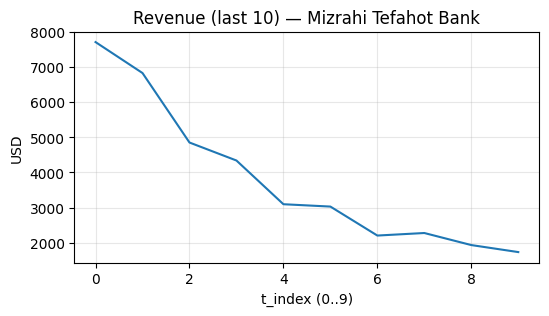

In [22]:
if ts is None or ts.empty:
    print("No timeseries to plot.")
else:
    # Find a company with revenue history
    g = ts[ts["metric"]=="revenue"].dropna(subset=["value"]).groupby("naturalId")["value"].count()
    if g.empty:
        print("No companies with revenue history found.")
    else:
        nid = g.sort_values(ascending=False).index[0]
        name = m.loc[m["naturalId"]==nid, "company"].astype(str).iloc[0] if (m["naturalId"]==nid).any() else str(nid)
        sub = ts[(ts["naturalId"]==nid) & (ts["metric"]=="revenue")].sort_values("t_index")
        plt.figure(figsize=(6,3))
        plt.plot(sub["t_index"], sub["value"])  # no specific colors/styles
        plt.title(f"Revenue (last 10) — {name}")
        plt.xlabel("t_index (0..9)")
        plt.ylabel("USD")
        plt.grid(True, alpha=0.3)
        plt.show()


### Cross-check: timeseries naturalID

In [23]:
if ts is not None and not ts.empty:
    master_ids = set(m["naturalId"].astype(str))
    ts_ids = set(ts["naturalId"].astype(str))
    missing_in_master = sorted(ts_ids - master_ids)
    print("naturalId present in ts but missing in master:", len(missing_in_master))
    if missing_in_master:
        pd.Series(missing_in_master).head(20)
else:
    print("Timeseries absent or empty; skipping cross-check.")


naturalId present in ts but missing in master: 0


### Slice stats & topics quick peek

In [24]:
if SLICE.exists():
    s = pd.read_parquet(SLICE)
    print("slice_stats rows:", len(s))
    s.head()
else:
    print("slice_stats not found — run scripts/02_enrich_and_split.py")

if TOPICS.exists():
    t = pd.read_parquet(TOPICS)
    print("slice_topics rows:", len(t))
    t.head()
else:
    print("slice_topics not found — run scripts/02_enrich_and_split.py")


slice_stats rows: 101
slice_topics rows: 101


### Optional CSV snapshots (for manual inspection)

In [25]:
SNAP_DIR = PARQUET_DIR.parent / "snapshots"
SNAP_DIR.mkdir(parents=True, exist_ok=True)

m.head(100).to_csv(SNAP_DIR / "master_head100.csv", index=False)
if ts is not None and not ts.empty:
    ts.head(1000).to_csv(SNAP_DIR / "timeseries_head1000.csv", index=False)
if SLICE.exists():
    pd.read_parquet(SLICE).head(200).to_csv(SNAP_DIR / "slice_stats_head200.csv", index=False)
if TOPICS.exists():
    pd.read_parquet(TOPICS).head(200).to_csv(SNAP_DIR / "slice_topics_head200.csv", index=False)

print("Saved CSV snapshots to:", SNAP_DIR)


Saved CSV snapshots to: /Users/vinothhaldorai/Documents/Vinoth/PROJECTS/forbes2000-explorer/data/snapshots
